In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/train/"))

# Any results you write to the current directory are saved as output.

['Fat Hen', 'Black-grass', 'Cleavers', 'Small-flowered Cranesbill', 'Sugar beet', 'Common Chickweed', 'Maize', 'Loose Silky-bent', 'Common wheat', 'Scentless Mayweed', 'Shepherds Purse', 'Charlock']


In [2]:
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# GLOBAL VARIABLES
scale = 70
seed = 7

Using TensorFlow backend.


In [3]:
path_to_images = '../input/train/*/*.png'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
#READING IMAGES AND RESIZING THEM
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
traininglabels = pd.DataFrame(traininglabels)

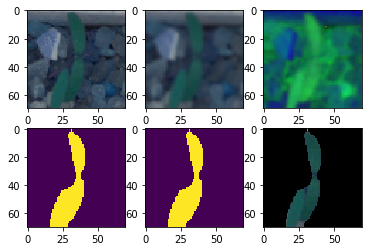

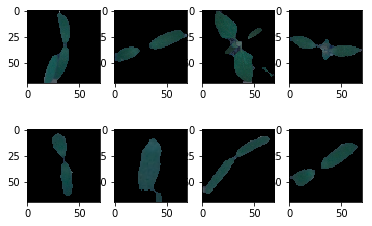

In [4]:
new_train = []
sets = []
getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


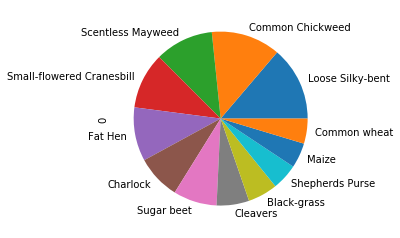

In [5]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

In [6]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [7]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [8]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)  

(4275, 70, 70, 3) (4275, 12)
(475, 70, 70, 3) (475, 12)
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
4275/4275 [==============================] - 10s 2ms/step - loss: 2.4900 - acc: 0.2910
Epoch 2/50
4275/4275 [==============================] - 4s 986us/step - loss: 1.7486 - acc: 0.4267
Epoch 3/50
4275/4275 [==============================] - 4s 984us/step - loss: 1.4684 - acc: 0.5102
Epoch 4/50
4275/4275 [==============================] - 4s 985us/step - loss: 1.1764 - acc: 0.5972
Epoch 5/50
4275/4275 [==============================] - 4s 983us/step - loss: 1.0208 - acc: 0.6515
Epoch 6/50
4275/4275 [==============================] - 4s 986us/step - loss: 0.8566 - acc: 0.7163
Epoch 7/50
4275/4275 [==============================] - 4s 993us/step - loss: 0.7918 - acc: 0.7284
Epoch 8/50
4275/4275 [==============================] - 4s 983us/step - loss: 0.7179 - acc: 0.7579
Epoch 9/50
4275/4275 [==============================] - 4s 984us/step - loss: 0.6081 - acc: 0.7920
Epoch 

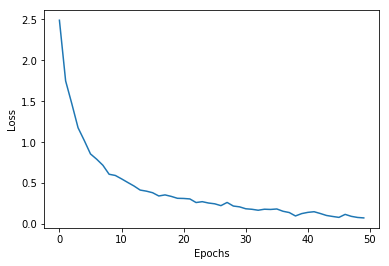

In [9]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
history = model.fit(x_train, y_train, epochs=50)

plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [10]:


pred_labels = model.predict(x_test)
print(pred_labels.shape)
acc = model.evaluate(x_test, y_test)
print("Testing accuracy : {}".format(acc[-1] * 100))

(475, 12)
475/475 [==============================] - 0s 849us/step
Testing accuracy : 82.31578951132926


In [11]:
import tensorflow as tf
# Save tf.keras model in HDF5 format.
keras_file = "keras_model.h5"
model.save(keras_file)

# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 50 variables.
INFO:tensorflow:Converted 50 variables to const ops.


13278472

[2.8085637e-07 8.4824428e-08 1.4665798e-07 1.2665058e-07 5.3877051e-07
 9.9999821e-01 1.9503356e-07 7.0045353e-08 3.4332686e-08 3.2880667e-08
 2.8255749e-07 6.0015104e-08]
5
Predicted label : Fat Hen


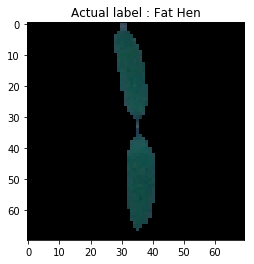

[4.9389450e-06 1.2066358e-09 2.4196609e-07 3.2648151e-09 9.9999356e-01
 2.3305340e-07 6.5403350e-07 7.1814910e-08 9.3930996e-09 3.0159781e-09
 1.6176471e-09 3.9975725e-07]
4
Predicted label : Common wheat


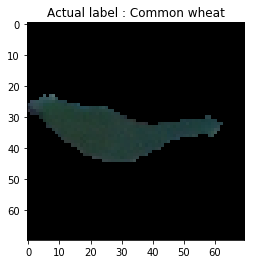

[1.1017918e-05 5.9021268e-02 8.7600944e-05 5.4971042e-05 8.9247318e-05
 9.6697324e-05 4.3659638e-06 8.1171376e-05 6.2614650e-05 9.3984711e-01
 5.7907344e-04 6.4969936e-05]
9
Predicted label : Shepherds Purse


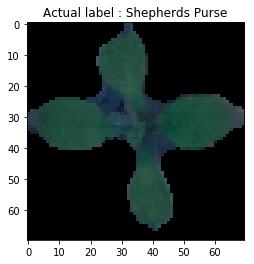

[6.9845437e-06 3.0578842e-06 6.5896762e-05 4.1565039e-05 8.9477044e-07
 6.6874883e-05 2.3196862e-05 1.3573260e-05 8.3988590e-07 2.1211252e-05
 9.9975115e-01 4.7495278e-06]
10
Predicted label : Small-flowered Cranesbill


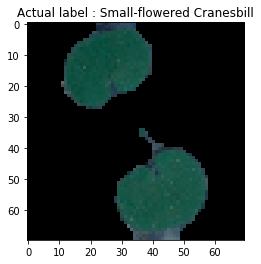

In [48]:
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

#122, 11, 223, 355
idxss = [122,11,223,355]
for idx in idxss:
    pred_label = model.predict(x_test)
    print(pred_label[idx])
    print(np.argmax(pred_label[idx], axis=0))
    print("Predicted label : " + str(labels.classes_[np.argmax(pred_label[idx], axis=0)]))

    plt.imshow(x_test[idx])
    plt.title("Actual label : " + str(labels.classes_[np.argmax(y_test[idx], axis=0)]))
    plt.show()

    img = x_test[idx]
    img_array = img_to_array(img)
    # save the image with a new filename
    save_img("test" + str(idx) + ".png", img_array)